### Outcome of best fine-tuned model on Food-101 Data

__Data Pre-Processing:__

All images were first rescaled to 256 x 256, and each class of 1,000 images was split into:

- Training - 664 images
- Validation - 136 images
- Testing - 200 images

__Data Augmentation:__

Training and validation images were further augmented to generate a total of 16 images per input image:

- Original image + mirror image
- 3 lightened images + mirror images
- 3 darkened images + mirror images
- Image rotated by 180 degrees by mirror image

__Solver.prototxt:__

- test_iter: 100
- test_interval: 1000
- base_lr: 0.001
- lr_policy: "step"
- gamma: 0.1
- stepsize: 3000
- display: 50
- max_iter: 30000
- momentum: 0.9
- weight_decay: 0.0005
- snapshot: 5000
- Batch size: 150
- Dropout: 0.5

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import caffe
import os
import numpy as np
import sys
import seaborn as sns

sys.path.append("/usr/local/caffe/tools/extra")
import parse_log as pl

sys.path.append('../')
import helpers.histogram_classifier as hc

In [2]:
from IPython.core.display import HTML
css = open('styles/table-style.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

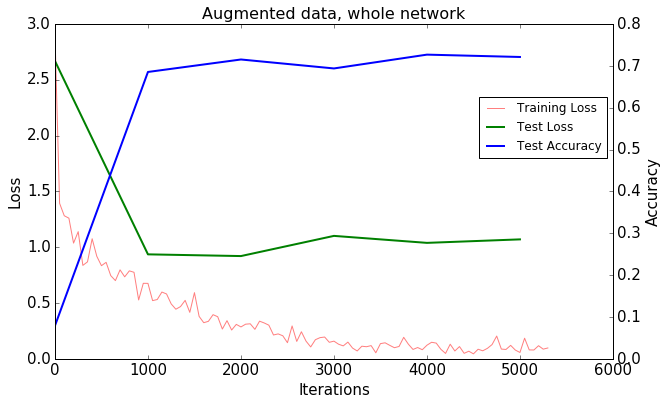

In [3]:
train_log, test_log = pl.parse_log("../transfer-learning/data/alexnet_4/train_7.log")
train_iters = [x['NumIters'] for x in train_log]
train_loss = [x['loss'] for x in train_log]
test_iters = [x['NumIters'] for x in test_log]
test_loss = [x['loss'] for x in test_log]
test_accuracy = [x['accuracy'] for x in test_log]
fig, ax1 = plt.subplots(figsize=(10,6))

# Plotting training and test losses
train_l ,= ax1.plot(train_iters, train_loss, color='red',  alpha=.5, label='Training loss')
test_l ,= ax1.plot(test_iters, test_loss, linewidth=2, color='green', label='Test loss')
#ax1.set_ylim(ymin=0, ymax=200)
ax1.set_xlabel('Iterations', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)
ax1.tick_params(labelsize=15)
#Plotting test accuracy
ax2 = ax1.twinx()
test_acc ,= ax2.plot(test_iters, test_accuracy, linewidth=2, color='blue', label='Test accuracy')
#ax2.set_ylim(ymin=0, ymax=1)
ax2.set_ylabel('Accuracy', fontsize=15)
ax2.tick_params(labelsize=15)
#Adding legend
plt.legend([train_l, test_l, test_acc], ['Training Loss', 'Test Loss', 'Test Accuracy'],  bbox_to_anchor=(1, 0.8))
plt.title('Augmented data, whole network', fontsize=16)
plt.show()

In [4]:
# Get true classes
prediction_mapping = eval(open('../transfer-learning/data/alexnet_3/class_mapping.txt', 'r').read())
reverse_prediction_mapping = { v:k for k,v in prediction_mapping.items() }
classes = [reverse_prediction_mapping[x] for x in range(12)]

true = []
with open("../transfer-learning/data/alexnet_3/test.txt", "r") as f:
    test_images = f.read().splitlines()

for x in test_images:
    true.append(reverse_prediction_mapping[int(x.split(" ")[1])])

In [5]:
# Get predictions
predictions = np.load("../transfer-learning/data/alexnet_4/augmented_7", encoding='latin1')

# Get true and predicted classes
predicted = []

for x in predictions:
    predicted.append(reverse_prediction_mapping[np.argmax(x)])

score, metrics, confusion = hc.get_metrics(true, predicted, classes)
score

,Accuracy,F1,Precision,Recall
Results,0.751,0.749,0.755,0.751


In [6]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.70,0.54,0.61,200.0
lasagna,0.73,0.76,0.74,200.0
french_toast,0.72,0.71,0.72,200.0
guacamole,0.90,0.93,0.92,200.0
apple_pie,0.61,0.74,0.67,200.0
cheesecake,0.73,0.72,0.72,200.0
hamburger,0.76,0.86,0.80,200.0
fried_rice,0.71,0.92,0.80,200.0
carrot_cake,0.74,0.74,0.74,200.0
chocolate_cake,0.86,0.73,0.79,200.0


In [7]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,108,19,12,0,11,2,12,13,1,0,21,1
lasagna,1,153,5,3,7,4,4,10,1,1,3,8
french_toast,4,7,142,2,18,6,12,3,3,0,1,2
guacamole,0,1,0,186,0,1,3,5,0,2,1,1
apple_pie,0,6,12,0,147,7,5,9,9,0,2,3
cheesecake,0,1,4,1,20,143,4,1,8,13,4,1
hamburger,1,1,6,2,5,6,171,1,1,1,5,0
fried_rice,2,0,0,5,3,0,1,185,3,0,0,1
carrot_cake,0,3,1,0,15,14,0,13,147,4,1,2
chocolate_cake,1,0,7,0,5,9,1,3,19,146,8,1


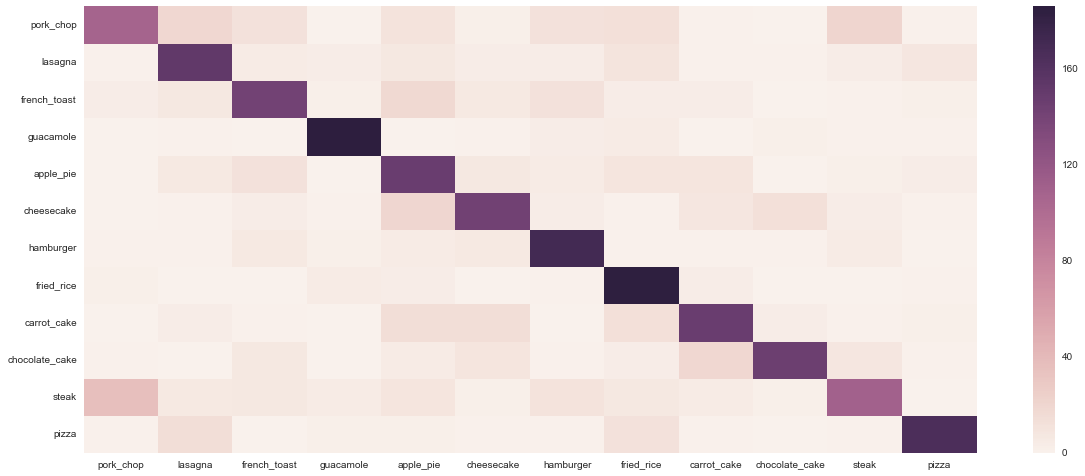

In [9]:
fig, ax = plt.subplots(figsize=(20,8))
sns.heatmap(confusion)
plt.show()

### Per class Precision-Recall curves

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [12]:
y_probs = predictions
y_test = np.array(true)

In [13]:
precision = dict()
recall = dict()
average_precision = dict()
for i, c in enumerate(classes):
    t = (y_test == c).astype(int)
    s = y_probs[:, i]
    precision[c], recall[c], _ = precision_recall_curve(t, s)
    average_precision[c] = average_precision_score(t, s)

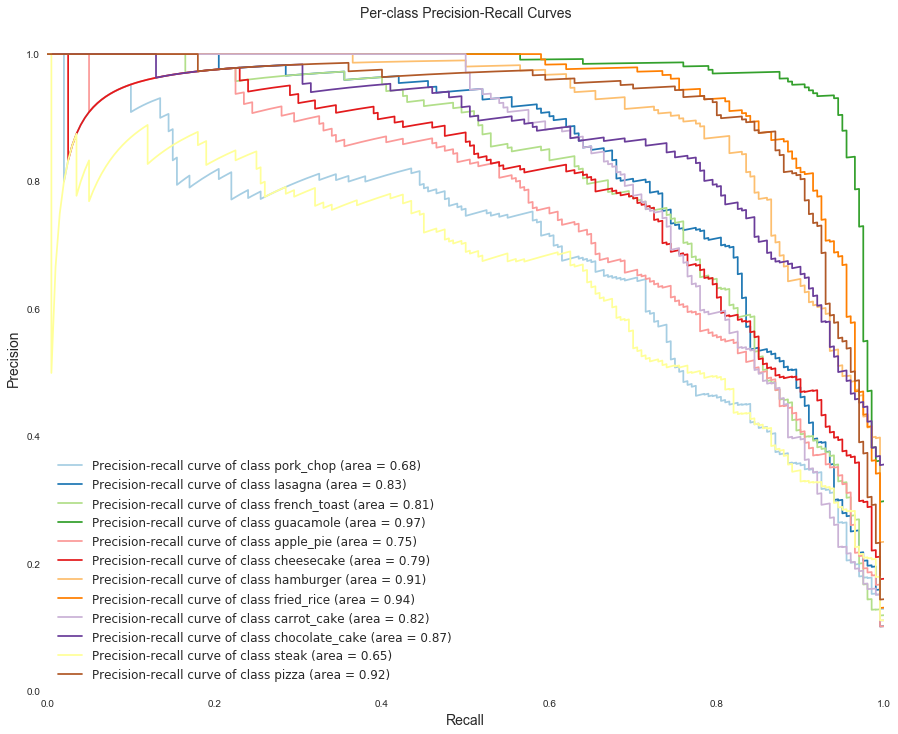

In [14]:
# Plot Precision-Recall curve for each class
colors = ('#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928')
fig, ax = plt.subplots(figsize=(15,12))
ax.set_axis_bgcolor('white')
for cl, co in zip(classes, colors):
    plt.plot(recall[cl], precision[cl], color=co,
             label='Precision-recall curve of class {} (area = {:.2f})'.format(cl, average_precision[cl]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.title('Per-class Precision-Recall Curves', size=14)
plt.legend(loc="lower left", prop={'size':12})
plt.show()

### Accuracy for top 2 classes

In [16]:
hc.top_n_class_accuracy(y_probs, classes, np.array(true), 2)

0.8770833333333333

### Visualize Network

In [17]:
caffe.set_mode_cpu()

model_def = '../transfer-learning/models/alexnet_4/deploy.prototxt'
model_weights = '../transfer-learning/models/alexnet_4/_iter_5000.caffemodel'

net = caffe.Net(model_def, model_weights, caffe.TEST)

In [18]:
mu = np.load('../transfer-learning/data/alexnet_4/alexnet_4_mean.npy')
mu = mu.mean(1).mean(1)
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

net.blobs['data'].reshape(50, 3, 227, 227)  # image size is 227x227

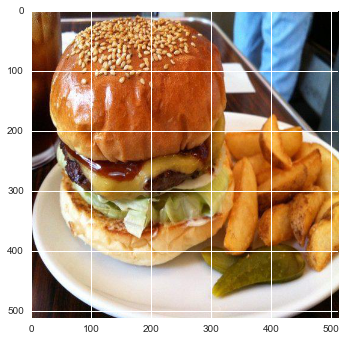

In [43]:
image = caffe.io.load_image('../data/food-101/top_classes/hamburger/1879189.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [44]:
net.blobs['data'].data[...] = transformed_image
output = net.forward()

In [45]:
for layer_name, param in net.params.items():
    print (layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape))

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8_food	(12, 4096) (12,)


In [46]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

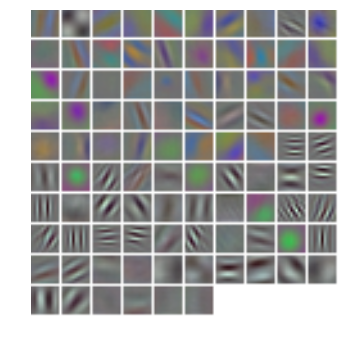

In [47]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

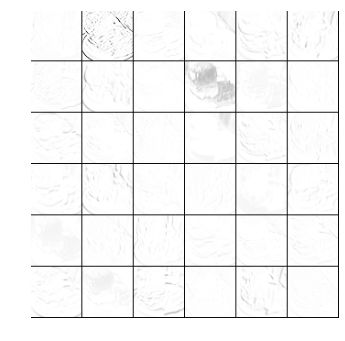

In [51]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat)

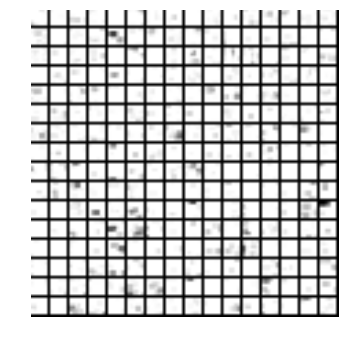

In [52]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)